In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gzip
from collections import defaultdict
import math
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import seaborn as sns

2023-12-04 11:24:59.382835: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 11:24:59.382860: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 11:24:59.382880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 11:24:59.387600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [3]:
game_meta = []
users = []

In [4]:
for d in readGz("steam_games.json.gz"):
    game_meta.append(d)
for d in readGz("australian_users_items.json.gz"):
    #remove all user without purchase
    if len(d['items']) > 0:
        users.append(d)

In [5]:
prices = []

In [6]:
def price_to_text(price):
    if type(price) == str:
        return "Free to Play"
    price = float(price)
    prices.append(price)
    if price<10:
        return "low-price"
    if price<35:
        return "medium-price"
    return "high-price"

In [7]:
all_genre_tags = defaultdict(int)
game_tags = defaultdict(set)
count = 0
for d in game_meta:
    keys = d.keys()
    if ('id' not in keys):
        #print(d)
        if (d['url'] == 'http://store.steampowered.com/app/200260'):
            g = 200260
        else:
            continue
    else:
        g = d['id']
    if 'price' not in keys:
        game_tags[g].add('Free to Play')
    else:
        game_tags[g].add(price_to_text(d['price']))
    if ('tags' in keys):      
        for tag in d['tags']:
            game_tags[g].add(tag)
    if ('genres' in keys):
        for genre in d['genres']:
            game_tags[g].add(genre)
    # if ('specs' in keys):
    #     for spec in d['specs']:
    #         game_tags[g].add(spec)
    count+=1
    for tag in game_tags[g]:
        all_genre_tags[tag] += 1

In [9]:
sorted_tags = sorted(list(all_genre_tags.keys()), key = lambda x: all_genre_tags[x], reverse = True)
all_genre_tags[sorted_tags[30]]

1234

In [10]:
sum([all_genre_tags[t] for t in sorted_tags[:30]])/30

4630.733333333334

In [11]:
[all_genre_tags[t] for t in sorted_tags[:30]]

[22402,
 17642,
 13018,
 9842,
 9767,
 7749,
 7576,
 5929,
 5628,
 4393,
 4346,
 2383,
 2235,
 2111,
 1947,
 1945,
 1935,
 1796,
 1600,
 1449,
 1446,
 1388,
 1363,
 1332,
 1319,
 1313,
 1303,
 1289,
 1241,
 1235]

In [12]:
len(sorted_tags)

345

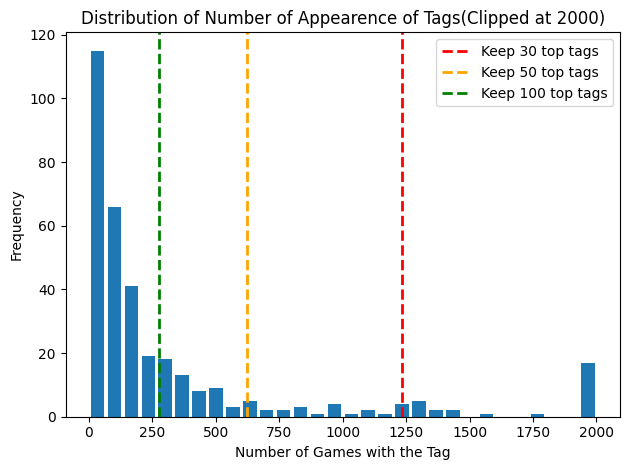

In [13]:
plt.hist(np.clip(list(all_genre_tags.values()),0,2000), bins=30, rwidth=0.8)

# Adding labels and title (optional)
plt.xlabel('Number of Games with the Tag')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Appearence of Tags(Clipped at 2000)')
plt.axvline(x=all_genre_tags[sorted_tags[30]], color='red', linestyle='--', linewidth=2, label='Keep 30 top tags')
plt.axvline(x=all_genre_tags[sorted_tags[50]], color='orange', linestyle='--', linewidth=2, label='Keep 50 top tags')
plt.axvline(x=all_genre_tags[sorted_tags[100]], color='green', linestyle='--', linewidth=2, label='Keep 100 top tags')
# Show the plot
plt.legend()
plt.tight_layout()
plt.savefig("tag_appearnce_hist.png")
plt.show()

In [14]:
game_purchased_count = defaultdict(int)
count = 0
for d in users:
    items = d['items']
    for item in items:
        count += 1
        if (item['playtime_forever'] > 60):
            game_purchased_count[item['item_id']] += 1
count

5153209

In [15]:
game_purchased_count_sorted = sorted(list(game_purchased_count.keys()), key = lambda x: game_purchased_count[x], reverse = True)

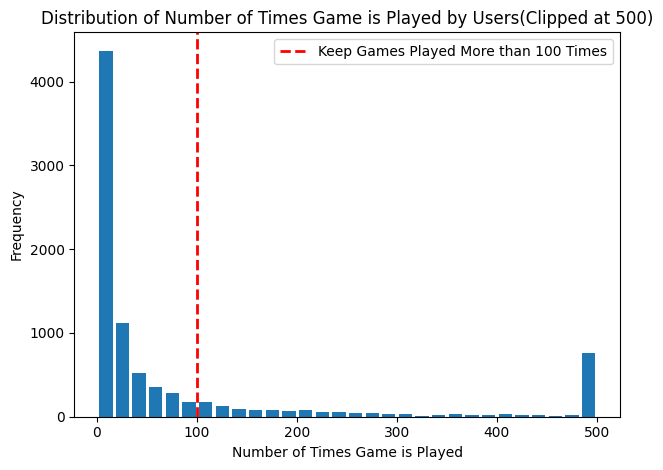

In [16]:
plt.hist(np.clip(list(game_purchased_count.values()),0,500), bins=30, rwidth=0.8)

# Adding labels and title (optional)
plt.xlabel('Number of Times Game is Played')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Times Game is Played by Users(Clipped at 500)')
plt.axvline(x=100, color='red', linestyle='--', linewidth=2, label='Keep Games Played More than 100 Times')
# Show the plot
plt.legend()
plt.tight_layout()
plt.savefig("game_played_hist.png")
plt.show()

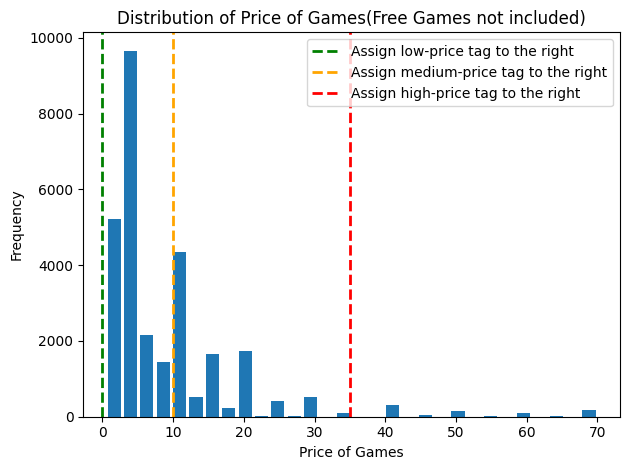

In [17]:
plt.hist(np.clip(prices,0,70), bins=30, rwidth=0.8)

# Adding labels and title (optional)
plt.xlabel('Price of Games')
plt.ylabel('Frequency')
plt.title("Distribution of Price of Games(Free Games not included)")
plt.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Assign low-price tag to the right')
plt.axvline(x=10, color='orange', linestyle='--', linewidth=2, label='Assign medium-price tag to the right')
plt.axvline(x=35, color='red', linestyle='--', linewidth=2, label='Assign high-price tag to the right')
# Show the plot
plt.legend()
plt.tight_layout()
plt.savefig("price_hist.png")
plt.show()

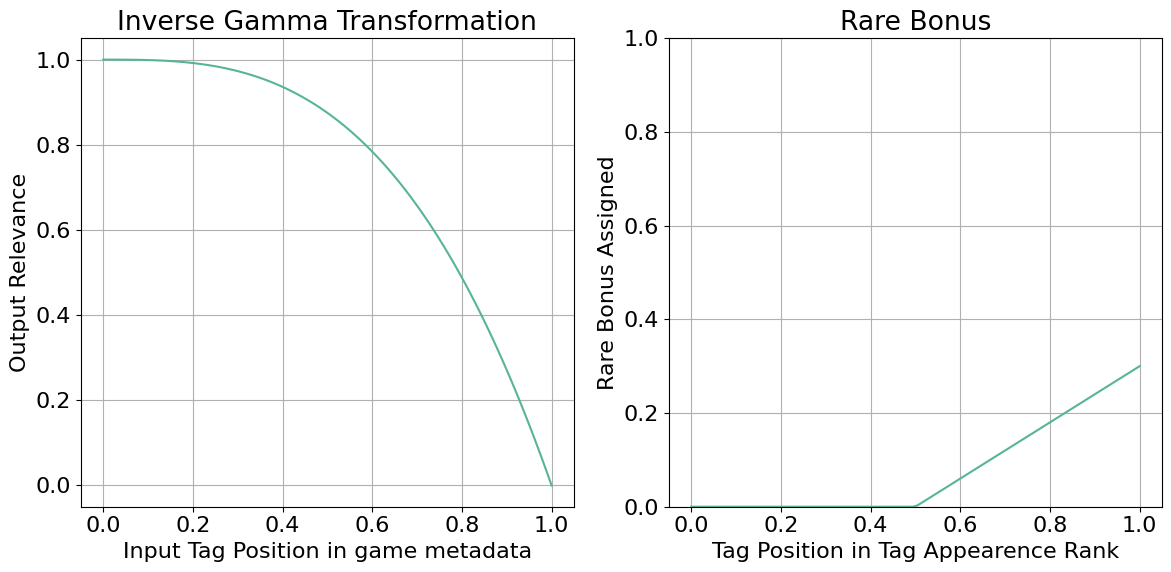

In [107]:
def piecewise_function(x):
    return np.where(x < 0.5, 0, 0.6 * x - 0.3)
plt.figure(figsize=(12, 6))
gamma = 3
x = np.linspace(0, 1, 100)
y_piecewise = piecewise_function(x)
y = 1 - x ** gamma
plt.rcParams.update({'font.size': 16})
plt.subplot(1, 2, 1)
plt.plot(x, y, label=f'Inverse Gamma Transformation (gamma={gamma})', color='#57b49b')
plt.title('Inverse Gamma Transformation')
plt.xlabel('Input Tag Position in game metadata')
plt.ylabel('Output Relevance')
#plt.legend()
plt.grid(True)

# Plotting the piecewise function with the area filled
plt.subplot(1, 2, 2)
plt.plot(x, y_piecewise, label='Piecewise Function\nf = 0 if x < 0.5\nf = 0.6x - 0.3 if 0.5 < x < 1', color='#57b49b')
plt.title('Rare Bonus')
plt.xlabel('Tag Position in Tag Appearence Rank')
plt.ylabel('Rare Bonus Assigned')
plt.ylim(0, 1)  # Setting the y-axis limit to 1
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("transformation.png")
plt.show()

In [117]:
data = {
    (30, 0.001, 0): 3.5960641860961915,
    (30, 0.001, 20): 2.770968699455261,
    (30, 0.001, 40): 2.663127326965332,
    (30, 0.001, 60): 2.673240041732788,
    (30, 0.001, 80): 2.6496713876724245,
    (30, 0.001, 100): 2.632195568084717,
    (30, 0.0001, 0): 3.5925827026367188,
    (30, 0.0001, 20): 2.7711607456207275,
    (30, 0.0001, 40): 2.6644452571868897,
    (30, 0.0001, 60): 2.6659401655197144,
    (30, 0.0001, 80): 2.648909664154053,
    (30, 0.0001, 100): 2.6273096561431886,
    (50, 0.001, 0): 3.5926591873168947,
    (50, 0.001, 20): 2.770169496536255,
    (50, 0.001, 40): 2.68430643081665,
    (50, 0.001, 60): 2.660231924057007,
    (50, 0.001, 80): 2.648494243621826,
    (50, 0.001, 100): 2.6229490995407105,
    (50, 0.0001, 0): 3.5917643308639526,
    (50, 0.0001, 20): 2.763747715950012,
    (50, 0.0001, 40): 2.680933427810669,
    (50, 0.0001, 60): 2.661432671546936,
    (50, 0.0001, 80): 2.6484280109405516,
    (50, 0.0001, 100): 2.6206633329391478,
    (100, 0.001, 0): 3.5933456420898438,
    (100, 0.001, 20): 2.765173006057739,
    (100, 0.001, 40): 2.6763715744018555,
    (100, 0.001, 60): 2.663679814338684,
    (100, 0.001, 80): 2.648302745819092,
    (100, 0.001, 100): 2.628220224380493,
    (100, 0.0001, 0): 3.5928473234176637,
    (100, 0.0001, 20): 2.7630360603332518,
    (100, 0.0001, 40): 2.676262879371643,
    (100, 0.0001, 60): 2.6615904331207276,
    (100, 0.0001, 80): 2.6530261516571043,
    (100, 0.0001, 100): 2.61996009349823
}

In [127]:
data_lfm = {
 20: 2.9304383,
 40: 2.7960825,
 60: 2.7315423,
 80: 2.7124367,
 100: 2.7073271}

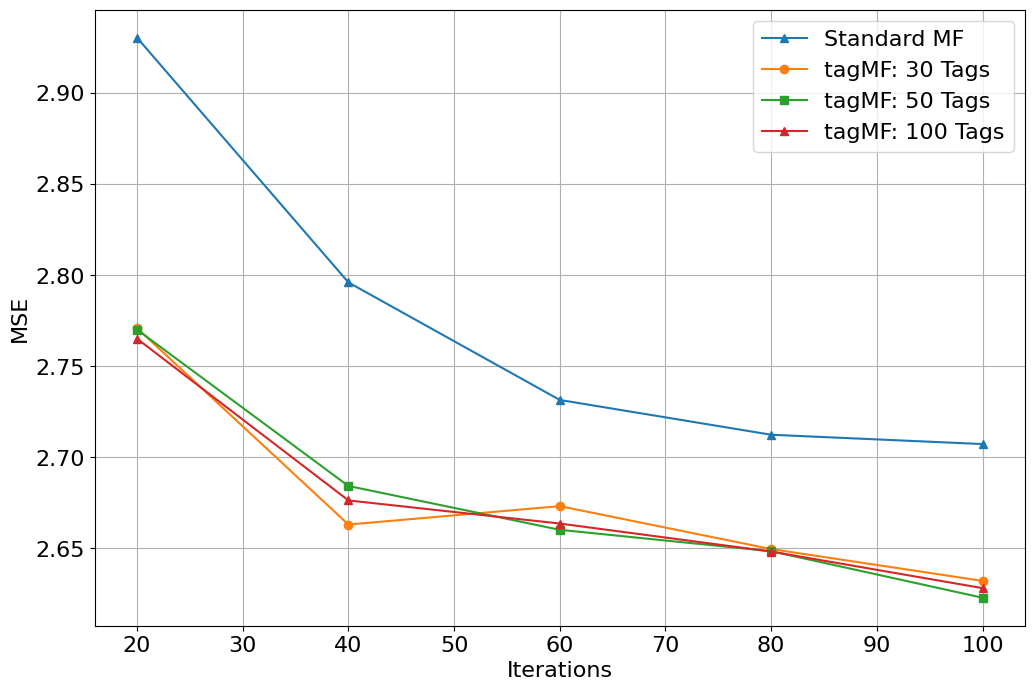

In [141]:
tags_30 = {k: v for k, v in data.items() if k[0] == 30 and k[1] == 0.001 and k[2] != 0}
tags_50 = {k: v for k, v in data.items() if k[0] == 50 and k[1] == 0.001 and k[2] != 0}
tags_100 = {k: v for k, v in data.items() if k[0] == 100 and k[1] == 0.001 and k[2] != 0}

# Sorting by iterations
tags_30 = dict(sorted(tags_30.items(), key=lambda item: item[0][2]))
tags_50 = dict(sorted(tags_50.items(), key=lambda item: item[0][2]))
tags_100 = dict(sorted(tags_100.items(), key=lambda item: item[0][2]))

# Extracting iterations and MSE values
iterations_30, mse_30 = zip(*[(k[2], v) for k, v in tags_30.items()])
iterations_50, mse_50 = zip(*[(k[2], v) for k, v in tags_50.items()])
iterations_100, mse_100 = zip(*[(k[2], v) for k, v in tags_100.items()])
iterations_lfm, mse_lfm = zip(*[(k, v) for k, v in data_lfm.items()])
# Plotting
plt.figure(figsize=(12, 8))

plt.plot(iterations_lfm, mse_lfm, label='Standard MF', marker='^')
plt.plot(iterations_30, mse_30, label='tagMF: 30 Tags', marker='o')
plt.plot(iterations_50, mse_50, label='tagMF: 50 Tags', marker='s')
plt.plot(iterations_100, mse_100, label='tagMF: 100 Tags', marker='^')


plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_1.png")
# Show plot
plt.show()

In [142]:
data_lfm = {
 20: 2.9304383,
 40: 2.7960825,
 60: 2.7315423,
 80: 2.7124367,
 100: 2.7073271}

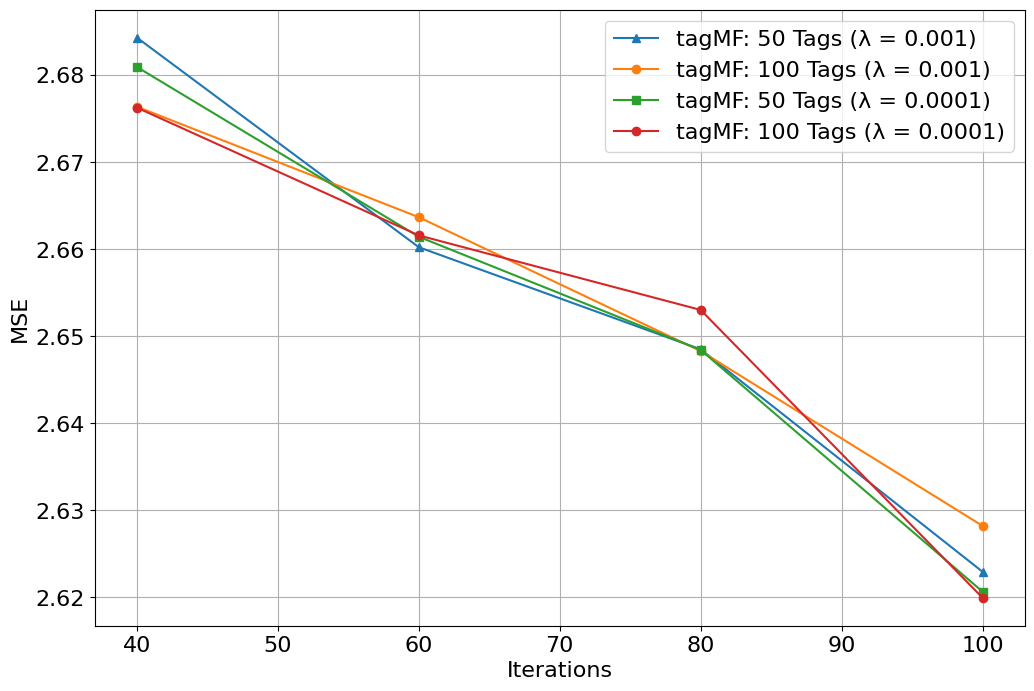

In [143]:
tags_50_l2 = {k: v for k, v in data.items() if k[0] == 50 and k[1] == 0.001 and k[2] != 0 and k[2] != 20}
tags_100_l2 = {k: v for k, v in data.items() if k[0] == 100 and k[1] == 0.001 and k[2] != 0 and k[2] != 20}
tags_50_l3 = {k: v for k, v in data.items() if k[0] == 50 and k[1] == 0.0001 and k[2] != 0 and k[2] != 20}
tags_100_l3 = {k: v for k, v in data.items() if k[0] == 100 and k[1] == 0.0001 and k[2] != 0 and k[2] != 20}

# Sorting by iterations
tags_50_l2 = dict(sorted(tags_50_l2.items(), key=lambda item: item[0][2]))
tags_100_l2 = dict(sorted(tags_100_l2.items(), key=lambda item: item[0][2]))
tags_50_l3 = dict(sorted(tags_50_l3.items(), key=lambda item: item[0][2]))
tags_100_l3 = dict(sorted(tags_100_l3.items(), key=lambda item: item[0][2]))

# Extracting iterations and MSE values
iterations_50_l2, mse_50_l2 = zip(*[(k[2], v) for k, v in tags_50_l2.items()])
iterations_100_l2, mse_100_l2 = zip(*[(k[2], v) for k, v in tags_100_l2.items()])
iterations_50_l3, mse_50_l3 = zip(*[(k[2], v) for k, v in tags_50_l3.items()])
iterations_100_l3, mse_100_l3 = zip(*[(k[2], v) for k, v in tags_100_l3.items()])
iterations_lfm, mse_lfm = zip(*[(k, v) for k, v in data_lfm.items()])
# Plotting
plt.figure(figsize=(12, 8))

plt.plot(iterations_50_l2, mse_50_l2, label='tagMF: 50 Tags (λ = 0.001)', marker='^')
plt.plot(iterations_100_l2, mse_100_l2, label='tagMF: 100 Tags (λ = 0.001)', marker='o')

plt.plot(iterations_50_l3, mse_50_l3, label='tagMF: 50 Tags (λ = 0.0001)', marker='s')
plt.plot(iterations_100_l3, mse_100_l3, label='tagMF: 100 Tags (λ = 0.0001)', marker='o')

#plt.plot(iterations_lfm, mse_lfm, label='Standard MF (λ = 0.001)', marker='o')

plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.savefig("evaluation_2.png")
# Show plot
plt.show()

In [121]:
tags_30

{(30, 0.001, 0): 3.5960641860961915,
 (30, 0.0001, 0): 3.5925827026367188,
 (30, 0.001, 20): 2.770968699455261,
 (30, 0.0001, 20): 2.7711607456207275,
 (30, 0.001, 40): 2.663127326965332,
 (30, 0.0001, 40): 2.6644452571868897,
 (30, 0.001, 60): 2.673240041732788,
 (30, 0.0001, 60): 2.6659401655197144,
 (30, 0.001, 80): 2.6496713876724245,
 (30, 0.0001, 80): 2.648909664154053,
 (30, 0.001, 100): 2.632195568084717,
 (30, 0.0001, 100): 2.6273096561431886}

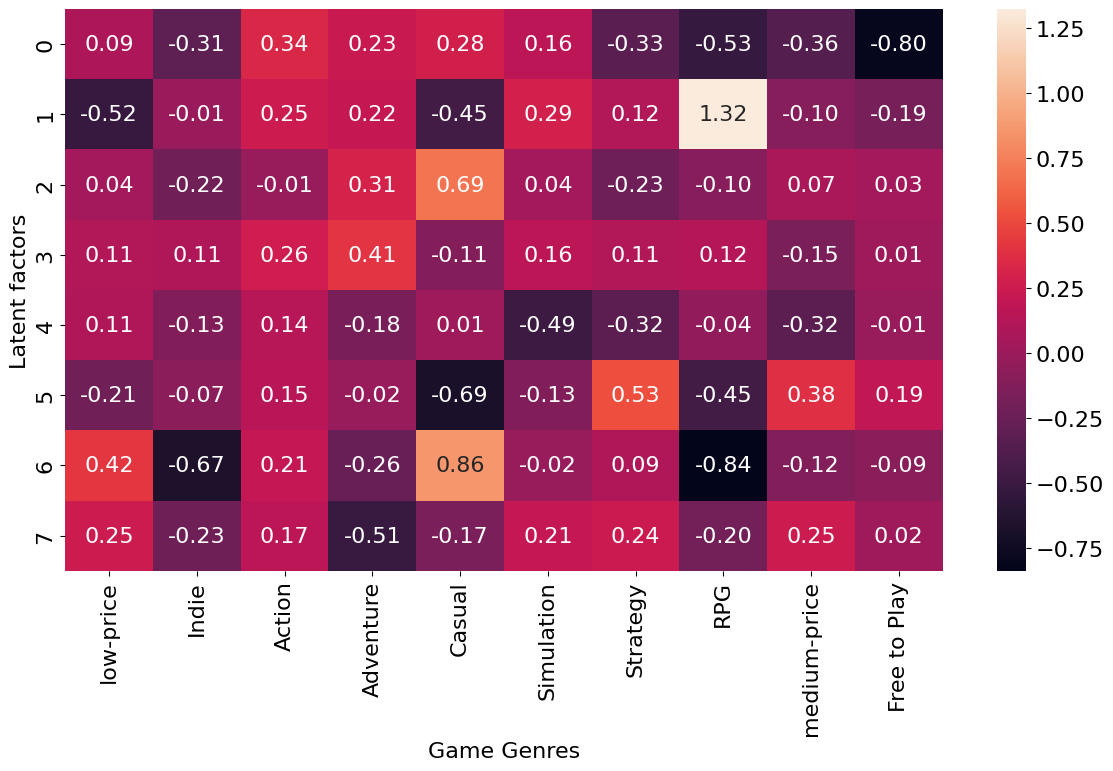

In [151]:
matrix = np.array([
    [0.08655585, -0.31059024, 0.34088385, 0.22870511, 0.28342706, 0.16156828, -0.32745996, -0.5270682, -0.35885203, -0.80280244],
    [-0.52094084, -0.00558778, 0.24897207, 0.21646231, -0.45195, 0.29141492, 0.11563437, 1.3226572, -0.10379349, -0.18671106],
    [0.03662562, -0.22050911, -0.01271682, 0.30618268, 0.6910591, 0.03599494, -0.2281576, -0.10191011, 0.07073135, 0.03287695],
    [0.11388445, 0.10570098, 0.26332816, 0.40769, -0.1146616, 0.16208254, 0.11109021, 0.11924891, -0.15399408, 0.00753842],
    [0.10828802, -0.13009731, 0.14095289, -0.17620967, 0.0103164, -0.4891214, -0.31590685, -0.04466379, -0.31548688, -0.01409433],
    [-0.20929673, -0.07328509, 0.14584465, -0.0157699, -0.6895931, -0.12830137, 0.5286995, -0.4495328, 0.3801405, 0.19117741],
    [0.41861397, -0.6682073, 0.20890467, -0.2615907, 0.8585488, -0.01509964, 0.09487591, -0.83612597, -0.12431882, -0.08743375],
    [0.24980608, -0.2340973, 0.16568728, -0.5113506, -0.16935717, 0.20903607, 0.24096833, -0.19609606, 0.24581468, 0.02028321]
])

x_labels = [
    'low-price',
    'Indie',
    'Action',
    'Adventure',
    'Casual',
    'Simulation',
    'Strategy',
    'RPG',
    'medium-price',
    'Free to Play'
]

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=x_labels, yticklabels=np.arange(matrix.shape[0]))
plt.xlabel('Game Genres')
plt.ylabel('Latent factors')
plt.tight_layout()
plt.savefig("relationship.png")
plt.show()